In [23]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

# Recommendation engine with a graph
>The purpose is to build a recommendation engine based on graph by using the Adamic Adar measure.<br/> The more the measure is high, the closest are the two nodes.<br/> The measures between all movies are NOT pre-calculated, in order to determine the list of recommendation films, we are going to explore the neighborhood of the target film

# How to take in account of the description ?

#### First idea ...
> In order to take in account the description, the movie are clustered by applying a KMeans clustering with TF-IDF weights <br/> So two movies that belong in a group of description will share a node.<br/> The fewer the number of films in the group, the more this link will be taken into account 

**but it doesn't work because clusters are too unbalanced*

#### Second idea ...
> In order to take in account the description, calcul the TF-IDF matrix <br/> and for each film, take the top 5 of similar descriptions and create a node Similar_to_this. This node will be taken in account in the Adamic Adar measure.

I have publish a notebook that explains what is "KMeans clustering with TF-IDF" here :
https://www.kaggle.com/yclaudel/find-similar-articles-with-tf-idf

# Adamic Adar measure
It is a measure used to compute the closeness of nodes based on their shared neighbors.

* x and y are 2 nodes (2 Movies)
* N(one_node) is a function that return the set of adjacent nodes  to one_node

$$ adamicAdar(x,y)=  \sum_{ u \in N(x) \cap N(y)} \frac{1}{log(N(u))}  $$

<span>&#171;</span>say otherwise, for each node u in common to x and y, add to the measure 1/log(N(u))<span>&#187;</span>

The quantity $ \frac{1}{log(N(u))} $ determine the importance of u in the measure.
* if x and y share a node u that has a lot of adjacent nodes, this node is not really relevant. <span>&#8594;</span> N(u) is high <span>&#8594;</span> 1/log(N(u)) is not high
* if x and y share a node u that **not** has a lot of adjacent nodes, this node is **really** relevant. <span>&#8594;</span> N(u) is **not** high <span>&#8594;</span> 1/log(N(u)) is higher


# Load the data

In [24]:
df = pd.read_csv('articles.csv')

In [25]:
df.head(2)

required_columns = ['prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name','department_name','index_name','index_group_name','section_name','garment_group_name','detail_desc']
df = df[required_columns]
display(df.head(2))

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,Strap top,Vest top,Garment Upper body,Solid,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,Strap top,Vest top,Garment Upper body,Solid,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.


In [4]:
import random
res = random.sample(range(1, 105542), 10000)
display(df.loc[res])

df = df.loc[res]

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
61884,2-p micro leggings long,Leggings/Tights,Garment Lower body,Solid,White,Young Girl S&T,Children Sizes 134-170,Baby/Children,Girls Underwear & Basics,Socks and Tights,Microfibre leggings with elastication at the w...
93772,Barcelona tunic dress,Dress,Garment Full body,Solid,Greenish Khaki,Dress,Ladieswear,Ladieswear,Womens Casual,Dresses Ladies,Short dress in an airy viscose weave with a co...
60115,Dorri linen shorts,Shorts,Garment Lower body,Solid,Dark Blue,Trouser,Ladieswear,Ladieswear,Womens Tailoring,Trousers,Shorts in an airy linen and viscose blend with...
17844,Sim mega hood,Sweater,Garment Upper body,Stripe,Dark Blue,Projects,Menswear,Menswear,Men Project,Unknown,"Top in sturdy, stripe-print sweatshirt fabric ..."
57005,Shaftless fancy OL 5p,Socks,Socks & Tights,All over pattern,Light Green,Baby Socks,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,Socks and Tights,Fine-knit trainer socks in a soft cotton blend...
...,...,...,...,...,...,...,...,...,...,...,...
32616,Dolly (Malva) thong 3pk,Underwear bottom,Underwear,Solid,Light Pink,Casual Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",NaN
75484,FRAME Easy Iron TVP,Shirt,Garment Upper body,Chambray,Blue,Shirt S&T,Menswear,Menswear,Men Suits & Tailoring,Shirts,Shirt in woven fabric with an easy-iron finish...
87765,Fav polo AOP,Polo shirt,Garment Upper body,All over pattern,Light Blue,Jersey License,Menswear,Menswear,Contemporary Street,Jersey Fancy,Short-sleeved polo shirt in patterned cotton p...
34766,Magnus shirt,Shirt,Garment Upper body,Check,Dark Turquoise,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,"Shirt in soft, brushed cotton twill with a gra..."


In [26]:
df.detail_desc.isna().value_counts()

False    105126
True        416
Name: detail_desc, dtype: int64

In [27]:
df.detail_desc = df.detail_desc.fillna(" ")

In [28]:
print(df.shape)

(105542, 11)


In [29]:
df.reset_index(inplace = True)

In [44]:
df_mod = df
df_mod.index = df.prod_name.tolist()

In [49]:
df_mod.loc[]

,index,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,cluster
Strap top,0,Strap top,Vest top,Garment Upper body,Solid,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,154
Strap top,1,Strap top,Vest top,Garment Upper body,Solid,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,154


# KMeans clustering with TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['detail_desc']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list) 
    
request_transform = vector.transform(df['detail_desc'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 

df['cluster'].value_counts().head()


C:\Users\dhrsingh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


109    4112
1      3398
191    2984
100    2789
27     2573
Name: cluster, dtype: int64

<div class="alert alert-block alert-warning"><span>&#171;</span>column cluster are not going to be used because clusters are two unbalanced <br/> But tfidf will be used in order to find similar description<span>&#187;</span></div>

In [32]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

# Load the graph (undirected graph)
Nodes are :
* Movies
* Person ( actor or director)
* Categorie
* Countrie
* Cluster (description)
* Sim(title) top 5 similar movies in the sense of the description

Edges are :
* ACTED_IN : relation between an actor and a movie
* CAT_IN : relation between a categrie and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* DESCRIPTION : relation between a cluster and a movie
* SIMILARITY in the sense of the description

<span>&#171;</span>so, two movies are not directly connected, but they share persons, categories,clusters and countries<span>&#187;</span>


In [33]:
G = nx.Graph(label="Clothing Store")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['prod_name'],label="Product")
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['product_type_name']:
        G.add_node(element,label="sub_cat")
        G.add_edge(rowi['prod_name'], element, label="sub_cat_of")
    for element in rowi['product_group_name']:
        G.add_node(element,label="category")
        G.add_edge(rowi['prod_name'], element, label="cat_of")
    for element in rowi['department_name']:
        G.add_node(element,label="Deaprtment")
        G.add_edge(rowi['prod_name'], element, label="department_of")
    for element in rowi['index_name']:
        G.add_node(element,label="Gender")
        G.add_edge(rowi['prod_name'], element, label="gender_type")
    
    
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.04929184913635254 seconds --
 iter 1000 -- 0.3222811222076416 seconds --
 iter 2000 -- 0.6297025680541992 seconds --
 iter 3000 -- 0.9286389350891113 seconds --
 iter 4000 -- 1.2650172710418701 seconds --
 iter 5000 -- 1.5765728950500488 seconds --
 iter 6000 -- 1.810924768447876 seconds --
 iter 7000 -- 2.0924935340881348 seconds --
 iter 8000 -- 2.350315809249878 seconds --
 iter 9000 -- 2.6105728149414062 seconds --
 iter 10000 -- 2.886915683746338 seconds --
 iter 11000 -- 3.179563283920288 seconds --
 iter 12000 -- 3.4451587200164795 seconds --
 iter 13000 -- 3.7206737995147705 seconds --
 iter 14000 -- 4.064182996749878 seconds --
 iter 15000 -- 4.360105276107788 seconds --
 iter 16000 -- 4.6992363929748535 seconds --
 iter 17000 -- 5.00949239730835 seconds --
 iter 18000 -- 5.306120872497559 seconds --
 iter 19000 -- 5.633570432662964 seconds --
 iter 20000 -- 5.947186470031738 seconds --
 iter 21000 -- 6.226258993148804 seconds --
 iter 22000 -- 6.534397602081299 s

# To see what's going on,a sub-graph with only two movies ...

In [19]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    node_color_list = [nc for _, nc in subgraph.nodes(data="node_color")]
    pos = nx.spring_layout(subgraph, seed=225)  # Seed for reproducible layout
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3, edge_color="k")
    nx.draw_networkx_nodes(subgraph, pos, alpha=0.8, node_color=node_color_list)
    nx.draw_networkx_labels(subgraph, pos, font_size=14)
    #nx.draw(subgraph, pos)
    nx.draw(
    subgraph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()} )
    
    plt.show()
    

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

edges = [['A', 'B'], ['B', 'C'], ['B', 'D']]
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={('A', 'B'): 'AB', 
                 ('B', 'C'): 'BC', 
                 ('B', 'D'): 'BD'},
    font_color='red'
)
plt.axis('off')
plt.show()

KeyError: '2-p micro leggings long'

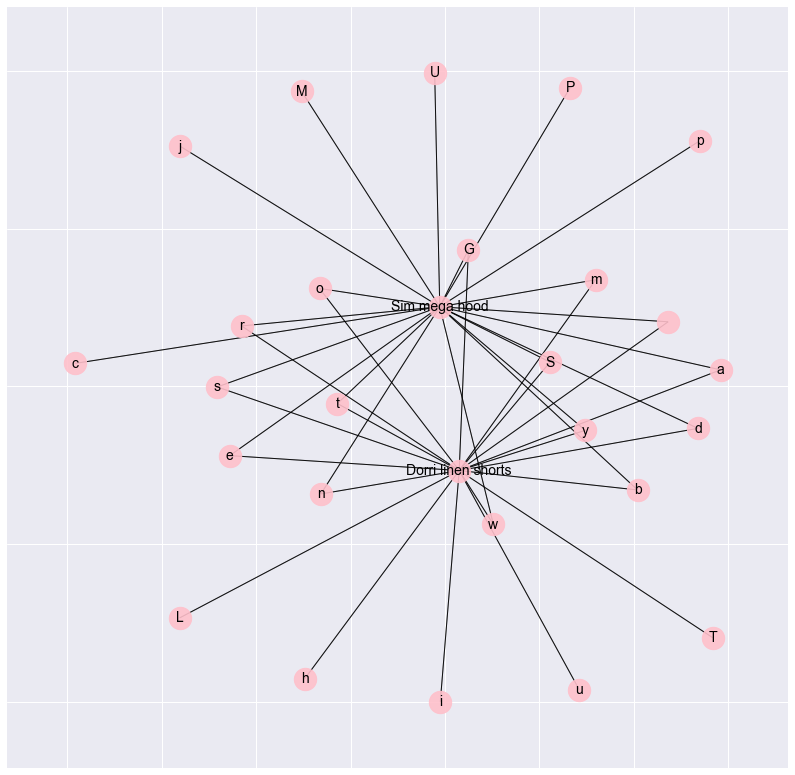

In [20]:
list_in=["Dorri linen shorts","Sim mega hood"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

# The recommendation function
<div class="alert alert-block alert-info">
<li> Explore the neighborhood of the target film <span>&#8594;</span> this is a list of actor, director, country, categorie</li>
<li> Explore the neighborhood of each neighbor <span>&#8594;</span> discover the movies that share a node with the target field</li>
<li> Calcul Adamic Adar measure <span>&#8594;</span> final results</li>
</div>

In [34]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="Product":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    product=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        product.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=product)
    result.sort_values(inplace=True,ascending=False)        
    return result;

# Let's test it ...

In [35]:
result = get_recommendation("Sim mega hood")
print("*"*40+"\n Recommendation for 'Sim mega hood'\n"+"*"*40)
print(result.head())


****************************************
 Recommendation for 'Sim mega hood'
****************************************
Sergio SS shirt      2.092987
CNY BLUE Yen L/S     2.092987
VALENTINE Hood       2.092987
Family 1 MAN Hood    2.092987
CNY FORTUNE HOOD     2.092987
dtype: float64


In [51]:
p1 ="Sim mega hood"
p2 = "Magnus shirt"
p3 = "2-p micro leggings long"

In [58]:
result = get_recommendation(p1)
result2 = get_recommendation(p2)
result3 = get_recommendation(p3)
print("*"*40+"\n Recommendation for " + p1 + " \n"+"*"*40)
display(df_mod.loc[p1])
display(df_mod.loc[result.index.tolist()].head())


****************************************
 Recommendation for Sim mega hood 
****************************************


index                                                                    17844
prod_name                                                        Sim mega hood
product_type_name                                                      Sweater
product_group_name                                          Garment Upper body
graphical_appearance_name                                               Stripe
colour_group_name                                                    Dark Blue
department_name                                                       Projects
index_name                                                            Menswear
index_group_name                                                      Menswear
section_name                                                       Men Project
garment_group_name                                                     Unknown
detail_desc                  Top in sturdy, stripe-print sweatshirt fabric ...
cluster                                             

,index,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,cluster
Sergio SS shirt,22134,Sergio SS shirt,Shirt,Garment Upper body,Stripe,Black,Projects,Menswear,Menswear,Men Project,Unknown,Striped shirt in a cotton weave with a grandad...,1
CNY BLUE Yen L/S,86963,CNY BLUE Yen L/S,Sweater,Garment Upper body,Placement print,Yellow,Projects,Menswear,Menswear,Men Project,Unknown,Top in soft cotton jersey with print motifs. R...,43
CNY BLUE Yen L/S,86964,CNY BLUE Yen L/S,Sweater,Garment Upper body,Placement print,Off White,Projects,Menswear,Menswear,Men Project,Unknown,Top in soft cotton jersey with print motifs. R...,43
VALENTINE Hood,64279,VALENTINE Hood,Sweater,Garment Upper body,Application/3D,Black,Projects,Menswear,Menswear,Men Project,Unknown,Top in sweatshirt fabric with a rubber appliqu...,82
Family 1 MAN Hood,104233,Family 1 MAN Hood,Sweater,Garment Upper body,Colour blocking,Dark Blue,Projects,Menswear,Menswear,Men Project,Unknown,Block-coloured top in soft sweatshirt fabric w...,82


In [61]:
result = get_recommendation(p2)
print("*"*40+"\n Recommendation for " + p2 + " \n"+"*"*40)
print("*"*10 + "Product Information" + "*"*10 )
display(df_mod.loc[p2])
print("*"*10 + "Recommended Product Information" + "*"*10 )
display(df_mod.loc[result.index.tolist()].head())


****************************************
 Recommendation for Magnus shirt 
****************************************
**********Product Information**********


,index,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,cluster
Magnus shirt,34765,Magnus shirt,Shirt,Garment Upper body,Check,Yellow,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,"Shirt in soft, brushed cotton twill with a gra...",195
Magnus shirt,34766,Magnus shirt,Shirt,Garment Upper body,Check,Dark Turquoise,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,"Shirt in soft, brushed cotton twill with a gra...",195
Magnus shirt,34767,Magnus shirt,Shirt,Garment Upper body,Other structure,White,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,"Shirt in soft, brushed cotton twill with a gra...",195
Magnus shirt,46943,Magnus shirt,Shirt,Garment Upper body,Check,Dark Blue,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,"Shirt in soft, brushed cotton twill with a gra...",195
Magnus shirt,46944,Magnus shirt,Shirt,Garment Upper body,Check,Dark Grey,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,"Shirt in soft, brushed cotton twill with a gra...",195
Magnus shirt,71400,Magnus shirt,Shirt,Garment Upper body,Check,Dark Blue,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,"Shirt in soft, checked cotton twill with a lig...",126


**********Recommended Product Information**********


,index,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,cluster
Jason Fancy shirt,94788,Jason Fancy shirt,Shirt,Garment Upper body,Solid,White,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,Shirt in airy cotton poplin with a grandad col...,195
Jason Fancy shirt,94789,Jason Fancy shirt,Shirt,Garment Upper body,Solid,Light Blue,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,Shirt in airy cotton poplin with a grandad col...,195
TVP Blake,65940,TVP Blake,Shirt,Garment Upper body,Solid,Light Blue,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,Shirt in a cotton weave with a button-down col...,195
TVP Blake,65941,TVP Blake,Shirt,Garment Upper body,Solid,White,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,Shirt in a cotton weave with a button-down col...,195
TVP Blake,65942,TVP Blake,Shirt,Garment Upper body,All over pattern,White,Baby Boy Woven,Baby Sizes 50-98,Baby/Children,Baby Boy,Woven/Jersey/Knitted mix Baby,Shirt in a cotton weave with a button-down col...,195


In [62]:
result = get_recommendation(p3)
print("*"*40+"\n Recommendation for " + p3 + " \n"+"*"*40)
print("*"*10 + "Product Information" + "*"*10 )
display(df_mod.loc[p3])
print()
print("*"*10 + "Recommended Product Information" + "*"*10 )
display(df_mod.loc[result.index.tolist()].head())


****************************************
 Recommendation for 2-p micro leggings long 
****************************************
**********Product Information**********


,index,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,cluster
2-p micro leggings long,61882,2-p micro leggings long,Leggings/Tights,Garment Lower body,Solid,Black,Young Girl S&T,Children Sizes 134-170,Baby/Children,Girls Underwear & Basics,Socks and Tights,Microfibre leggings with elastication at the w...,28
2-p micro leggings long,61883,2-p micro leggings long,Leggings/Tights,Garment Lower body,Solid,Dark Blue,Young Girl S&T,Children Sizes 134-170,Baby/Children,Girls Underwear & Basics,Socks and Tights,Microfibre leggings with elastication at the w...,28
2-p micro leggings long,61884,2-p micro leggings long,Leggings/Tights,Garment Lower body,Solid,White,Young Girl S&T,Children Sizes 134-170,Baby/Children,Girls Underwear & Basics,Socks and Tights,Microfibre leggings with elastication at the w...,28
2-p micro leggings long,61895,2-p micro leggings long,Leggings/Tights,Garment Lower body,Solid,Light Pink,Kids Girl S&T,Children Sizes 92-140,Baby/Children,Girls Underwear & Basics,Socks and Tights,Microfibre leggings with elastication at the w...,28
2-p micro leggings long,61896,2-p micro leggings long,Leggings/Tights,Garment Lower body,Solid,White,Kids Girl S&T,Children Sizes 92-140,Baby/Children,Girls Underwear & Basics,Socks and Tights,Microfibre leggings with elastication at the w...,28
2-p micro leggings long,61897,2-p micro leggings long,Leggings/Tights,Garment Lower body,Solid,Dark Blue,Kids Girl S&T,Children Sizes 92-140,Baby/Children,Girls Underwear & Basics,Socks and Tights,Microfibre leggings with elastication at the w...,28
2-p micro leggings long,61898,2-p micro leggings long,Leggings/Tights,Garment Lower body,Solid,Black,Kids Girl S&T,Children Sizes 92-140,Baby/Children,Girls Underwear & Basics,Socks and Tights,Microfibre leggings with elastication at the w...,28



**********Recommended Product Information**********


,index,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,cluster
2-p micro leggings 3/4-length,61880,2-p micro leggings 3/4-length,Leggings/Tights,Garment Lower body,Solid,White,Young Girl S&T,Children Sizes 134-170,Baby/Children,Girls Underwear & Basics,Socks and Tights,3/4-length microfibre leggings with an elastic...,28
2-p micro leggings 3/4-length,61881,2-p micro leggings 3/4-length,Leggings/Tights,Garment Lower body,Solid,Black,Young Girl S&T,Children Sizes 134-170,Baby/Children,Girls Underwear & Basics,Socks and Tights,3/4-length microfibre leggings with an elastic...,28
2-p micro leggings 3/4-length,61887,2-p micro leggings 3/4-length,Leggings/Tights,Garment Lower body,Solid,White,Kids Girl S&T,Children Sizes 92-140,Baby/Children,Girls Underwear & Basics,Socks and Tights,3/4-length microfibre leggings with an elastic...,28
LEGGINGS FANCY,63758,LEGGINGS FANCY,Leggings/Tights,Garment Lower body,Denim,Dark Blue,Kids Girl Denim,Children Sizes 92-140,Baby/Children,Kids Girl,Trousers Denim,"Leggings in washed, stretch denim with an elas...",111
LEGGINGS FANCY,63760,LEGGINGS FANCY,Leggings/Tights,Garment Lower body,Denim,Light Blue,Kids Girl Denim,Children Sizes 92-140,Baby/Children,Kids Girl,Trousers Denim,"Leggings in washed, stretch denim with an elas...",111


In [53]:
result = get_recommendation(p1)
result2 = get_recommendation(p2)
result3 = get_recommendation(p3)
print("*"*40+"\n Recommendation for " + p1 + " \n"+"*"*40)
print(df_mod.loc[p1])
print(df_mod.loc[result.index.tolist()].head())
print("*"*40+"\n Recommendation for 'Lukas top'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Robin 10pk R Basic shorttrunk'\n"+"*"*40)
print(result3.head())


2-p micro leggings 3/4-length    3.716713
LEGGINGS FANCY                   3.590388
SARA cycle shorts                3.590388
HOLLY                            3.590388
2P Skinny Cheapo(1)              3.478614
                                   ...   
Babe bandeau                     0.657032
HOPE top                         0.657032
Brandy bra top                   0.657032
Babe Bandeau Bra                 0.657032
Dahlia top 3-pack.               0.657032
Length: 45830, dtype: float64

In [64]:
p4 = "Padded pyjama"
result = get_recommendation(p4)
print("*"*40+"\n Recommendation for " + p4 + " \n"+"*"*40)
print("*"*10 + "Product Information" + "*"*10 )
display(df_mod.loc[p4].head(1))
print()
print("*"*10 + "Recommended Product Information" + "*"*10 )
display(df_mod.loc[result.index.tolist()].head())


****************************************
 Recommendation for Padded pyjama 
****************************************
**********Product Information**********


,index,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,cluster
Padded pyjama,150,Padded pyjama,Pyjama jumpsuit/playsuit,Nightwear,All over pattern,White,Baby Nightwear,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,"Under-, Nightwear",Lightly padded all-in-one pyjamas in soft cott...,34



**********Recommended Product Information**********


,index,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,cluster
Velour pyjama,37,Velour pyjama,Pyjama jumpsuit/playsuit,Nightwear,Application/3D,White,Baby Nightwear,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,"Under-, Nightwear",Velour pyjamas with an appliqué detail at the ...,34
Velour pyjama,38,Velour pyjama,Pyjama jumpsuit/playsuit,Nightwear,Application/3D,Light Pink,Baby Nightwear,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,"Under-, Nightwear",Velour pyjamas with an appliqué detail at the ...,34
3P LS PJ feet/zip,56592,3P LS PJ feet/zip,Pyjama jumpsuit/playsuit,Nightwear,All over pattern,White,Baby Nightwear,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,"Under-, Nightwear",All-in-one pyjamas in soft organic cotton jers...,34
LS PJ DEAL,43635,LS PJ DEAL,Pyjama jumpsuit/playsuit,Nightwear,All over pattern,Dark Blue,Baby Nightwear,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,"Under-, Nightwear",All-in-one pyjamas in soft organic cotton jers...,34
LS PJ DEAL,43636,LS PJ DEAL,Pyjama jumpsuit/playsuit,Nightwear,All over pattern,White,Baby Nightwear,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,"Under-, Nightwear",All-in-one pyjamas in soft organic cotton jers...,34


# Draw top recommendations, to see the common nodes

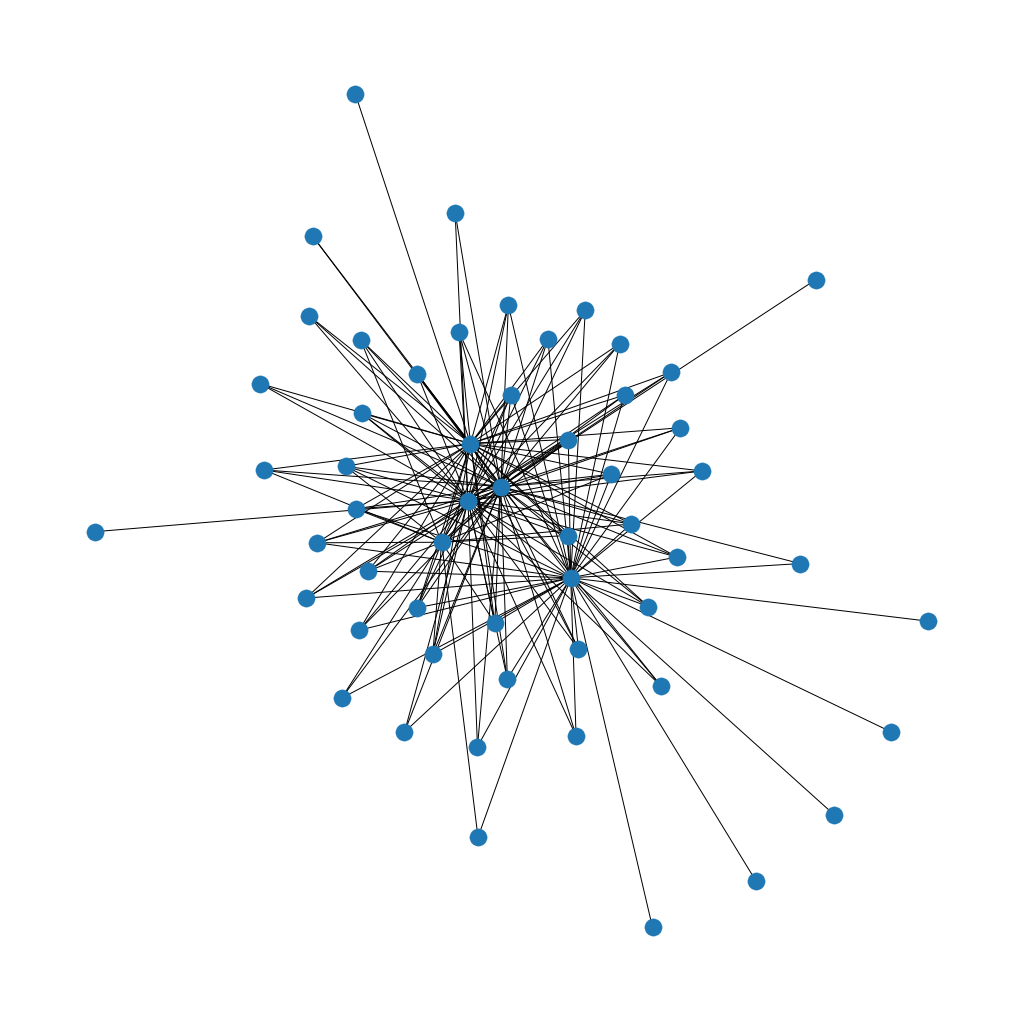

In [41]:
reco=list(result.index[:3].values)
reco.extend(["FLYGARE top"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

In [42]:
reco=list(result4.index[:4].values)
reco.extend(["Stranger Things"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

NameError: name 'result4' is not defined

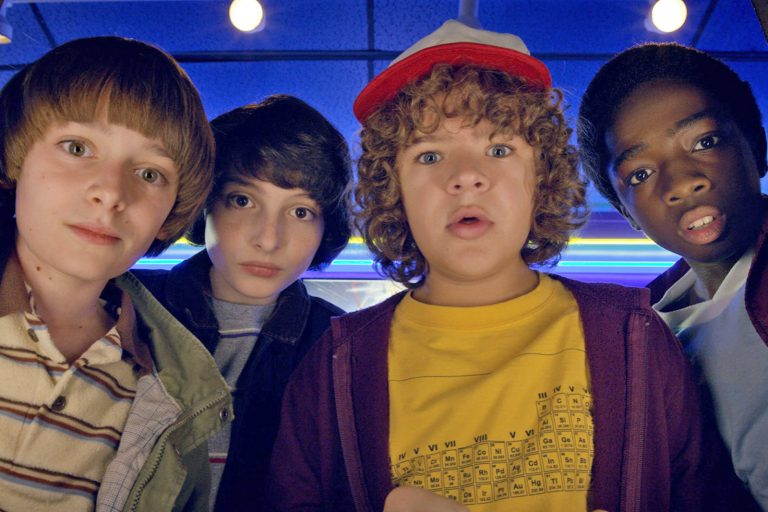

<div class="alert alert-block alert-info"><b><span>&#171;</span> please don't forget to upvote, that will keep me motivated <span>&#187;</span></b></div> 